#  Maximal Constraint-Admissible Invariant Set $\mathcal O_{\infty}$

For the autonomous discrete-time system
\begin{align}
x(t+1) = A x(t)
\end{align}
subject to the constraint
\begin{align}
x(t) \in \mathcal X,
\end{align}
the Maximal Constraint-Admissible Invariant Set (MCAIS) $\mathcal O_{\infty}$ [1] is the set such that
\begin{align}
x(0) \in \mathcal O_{\infty}
\Leftrightarrow
x(t) \in \mathcal X
\quad \text{for} \quad t=0,1,\ldots.
\end{align}
Note that $\mathcal O_{\infty}$ is positive invariant by definition.

## Demo

In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib.pyplot as plt

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem
from pympc.plot import plot_state_space_trajectory

Consider an inverted pendulum with mass $m$ and length $l$, subject to the gravity acceleration $g$

In [2]:
m = 1.
l = 1.
g = 10.

The linearized continuous-time dynamics is 
\begin{equation}
\dot x = A x + B u =
\begin{bmatrix}
0 & 1 \\ g/l & 0
\end{bmatrix}
x +
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix}
u
\end{equation}

In [3]:
A = np.array([
    [ 0., 1.],
    [g/l, 0.]
    ])
B = np.array([
    [          0.],
    [1./(m*l**2.)]
    ])

For a given sampling time $h$, the discrete-time linear system can be defined from its continuous-time representation

In [4]:
h = .01
method = 'zero_order_hold'
S = LinearSystem.from_continuous(A, B, h, method)

Consider now the linear quadratic optimal control problem
\begin{align}
V^*(x(0)) :=
\min_{x(\cdot), u(\cdot)} \quad &
\frac{1}{2} \sum_{t=0}^{\infty} ( x^T(t) Q x(t) + u^T(t) R u(t) ), \\
\text{subject to} \quad & x(t+1) = A x(t) + B u(t),
\end{align}
whose solution is the static linear feedback
\begin{align}
u(t) = K x(t)
\end{align}
and the quadratic cost-to-go
\begin{align}
V(x) = \frac{1}{2} x^T P x
\end{align}

In [5]:
Q = np.array([[1., 0.],[0., 1.]])
R = np.array([[1.]])
P, K = S.solve_dare(Q, R)

Consider then the polytopic constraints
\begin{align}
x(t) \in \mathcal X, \quad
u(t) \in \mathcal U \quad
\text{for} \quad
t=0,1,\ldots
\end{align}

In [6]:
x_min = np.array([[-1.],[-1.]])
x_max = np.array([[ 1.],[ 1.]])
X = Polyhedron.from_bounds(x_min, x_max)
u_min = np.array([[-15.]])
u_max = np.array([[ 15.]])
U = Polyhedron.from_bounds(u_min, u_max)

We now derive the MCAIS for the closed loop system
\begin{align}
x(t+1) = A_{\mathrm{cl}} x(t), \quad A_{\mathrm{cl}} := A + B K,
\end{align}
subject to the constraint
\begin{align}
x(t) \in \mathcal X_{\mathrm{cl}} \quad
\text{for} \quad
t=0,1,\ldots,
\end{align}
where $\mathcal X_{\mathrm{cl}}$ is the set such that
\begin{align}
x \in \mathcal X_{\mathrm{cl}}
\Leftrightarrow
(x, u = K x) \in \mathcal D,
\end{align}
with $\mathcal D := \mathcal X \times \mathcal U$

In [7]:
D = X.cartesian_product(U)
O_inf = S.mcais(K, D)

The previous function derives $A_{\mathrm{cl}}$ and $\mathcal X_{\mathrm{cl}}$ for us, but since we want to plot $\mathcal X_{\mathrm{cl}}$, we now derive it explicitly

In [8]:
U_cl = Polyhedron(U.A.dot(K), U.b)
X_cl = X.intersection(U_cl)

We can now plot the sets $\mathcal X$, $\mathcal X_{\mathrm{cl}}$, $\mathcal O_{\infty}$ and, in order to verify the properties of $\mathcal O_{\infty}$, we simulate the closed-loop system from various initial conditions

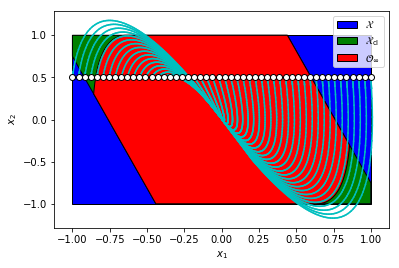

In [9]:
# plot sets
X.plot(label=r'$\mathcal{X}$', facecolor='b')
X_cl.plot(label=r'$\mathcal{X}_{\mathrm{cl}}$', facecolor='g')
O_inf.plot(label=r'$\mathcal{O}_{\infty}$', facecolor='r')

# plot simulations
N = 100
n_sim = 50
x_1 = .5
for x_0 in np.linspace(x_min[0], x_max[0], n_sim):
    x = np.array([[x_0],[x_1]])
    x_trajectory = S.simulate_closed_loop(x, N, K)
    plot_state_space_trajectory(x_trajectory, color='c')
plt.legend()
plt.show()

## References

[1] Gilbert, E.G. and Tan, K.T., 1991. Linear systems with state and control constraints: The theory and application of maximal output admissible sets. IEEE Transactions on Automatic control, 36(9), pp.1008-1020.